# EMA Cross Strategy

This notebook implements an EMA (Exponential Moving Average) cross strategy for trading. It includes data downloading, signal generation, backtesting, and parameter sensitivity analysis.

In [1]:
import logging
import os
import yfinance as yf
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Tuple, List

# Configuration
YEARS = 30  # Set timeframe in years for daily data
USE_HOURLY_DATA = False  # Set to False for daily data
USE_SYNTHETIC = False  # Toggle between synthetic and original ticker
TICKER_1 = 'PGR'  # Ticker for X to USD exchange rate
TICKER_2 = 'BTC-USD'  # Ticker for Y to USD exchange rate
SHORT = False  # Set to True for short-only strategy, False for long-only strategy
USE_SMA = False  # Set to True to use SMAs, False to use EMAs

# Logging setup
log_dir = 'logs'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
logging.basicConfig(filename=os.path.join(log_dir, 'ema_cross.log'), level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

## Data Download Function

In [2]:
def download_data(ticker: str, use_hourly: bool) -> pd.DataFrame:
    """Download historical data from Yahoo Finance."""
    interval = '1h' if use_hourly else '1d'
    end_date = datetime.now()
    start_date = end_date - timedelta(days=730 if use_hourly else 365 * YEARS)
    
    logging.info(f"Downloading data for {ticker}")
    try:
        data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
        logging.info(f"Data download for {ticker} completed successfully")
        return data
    except Exception as e:
        logging.error(f"Failed to download data for {ticker}: {e}")
        raise

## Signal Generation Function

In [3]:
def calculate_ma_and_signals(data: pd.DataFrame, short_window: int, long_window: int) -> pd.DataFrame:
    """Calculate MAs and generate trading signals."""
    ma_type = "SMA" if USE_SMA else "EMA"
    logging.info(f"Calculating {ma_type}s and signals with short window {short_window} and long window {long_window}")
    try:
        if USE_SMA:
            data['MA_short'] = data['Close'].rolling(window=short_window).mean()
            data['MA_long'] = data['Close'].rolling(window=long_window).mean()
        else:
            data['MA_short'] = data['Close'].ewm(span=short_window, adjust=False).mean()
            data['MA_long'] = data['Close'].ewm(span=long_window, adjust=False).mean()
        
        if SHORT:
            data['Signal'] = np.where(data['MA_short'] < data['MA_long'], -1, 0)
        else:
            data['Signal'] = np.where(data['MA_short'] > data['MA_long'], 1, 0)
        
        data['Position'] = data['Signal'].shift()
        logging.info(f"{ma_type}s and signals calculated successfully")
        return data
    except Exception as e:
        logging.error(f"Failed to calculate {ma_type}s and signals: {e}")
        raise

## Backtesting Function

In [4]:
def backtest_strategy(data: pd.DataFrame) -> vbt.Portfolio:
    """Backtest the MA cross strategy."""
    logging.info("Starting strategy backtest")
    try:
        freq = 'h' if USE_HOURLY_DATA else 'D'
        
        if SHORT:
            portfolio = vbt.Portfolio.from_signals(
                close=data['Close'],
                short_entries=data['Signal'] == -1,
                short_exits=data['Signal'] == 0,
                init_cash=1000,
                fees=0.001,
                freq=freq
            )
        else:
            portfolio = vbt.Portfolio.from_signals(
                close=data['Close'],
                entries=data['Signal'] == 1,
                exits=data['Signal'] == 0,
                init_cash=1000,
                fees=0.001,
                freq=freq
            )
        
        logging.info("Backtest completed successfully")
        return portfolio
    except Exception as e:
        logging.error(f"Backtest failed: {e}")
        raise

## Parameter Sensitivity Analysis Function

In [5]:
def parameter_sensitivity_analysis(data: pd.DataFrame, short_windows: List[int], long_windows: List[int]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Perform parameter sensitivity analysis."""
    logging.info("Starting parameter sensitivity analysis")
    try:
        results_return = pd.DataFrame(index=short_windows, columns=long_windows)
        results_expectancy = pd.DataFrame(index=short_windows, columns=long_windows)
        
        for short in short_windows:
            for long in long_windows:
                if short < long:
                    temp_data = calculate_ma_and_signals(data.copy(), short, long)
                    portfolio = backtest_strategy(temp_data)
                    results_return.loc[short, long] = portfolio.total_return()
                    trades = portfolio.trades
                    results_expectancy.loc[short, long] = trades.pnl.mean() if len(trades) > 0 else np.nan
        
        logging.info("Parameter sensitivity analysis completed successfully")
        return results_return, results_expectancy
    except Exception as e:
        logging.error(f"Parameter sensitivity analysis failed: {e}")
        raise

## Heatmap Plotting Function

In [6]:
def plot_heatmaps(results_return: pd.DataFrame, results_expectancy: pd.DataFrame, ticker: str) -> None:
    """Plot heatmaps of the results."""
    logging.info("Plotting heatmaps")
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
        
        sns.heatmap(results_return.astype(float), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Total Return'}, ax=ax1)
        timeframe = "Hourly" if USE_HOURLY_DATA else "Daily"
        ma_type = "SMA" if USE_SMA else "EMA"
        ax1.set_title(f'Total Return - {ma_type} Cross ({timeframe}) for {ticker}')
        ax1.set_xlabel('Long Period')
        ax1.set_ylabel('Short Period')
        
        sns.heatmap(results_expectancy.astype(float), annot=True, fmt=".2f", cmap="YlOrRd", cbar_kws={'label': 'Expectancy'}, ax=ax2)
        ax2.set_title(f'Expectancy - {ma_type} Cross ({timeframe}) for {ticker}')
        ax2.set_xlabel('Long Period')
        ax2.set_ylabel('Short Period')
        
        plt.tight_layout()
        plt.show()
        logging.info("Heatmaps plotted successfully")
    except Exception as e:
        logging.error(f"Failed to plot heatmaps: {e}")
        raise

## Best Parameters Function

In [7]:
def print_best_parameters(results_return: pd.DataFrame, results_expectancy: pd.DataFrame, ticker: str) -> Tuple[int, int, int, int]:
    """Find and print the best parameter combinations for return and expectancy."""
    try:
        best_params_return = results_return.stack().idxmax()
        best_return = results_return.stack().max()
        best_params_expectancy = results_expectancy.stack().idxmax()
        best_expectancy = results_expectancy.stack().max()
        
        ma_type = "SMA" if USE_SMA else "EMA"
        print(f"Best parameters for {ticker} using {ma_type}:")
        print(f"Total Return: Short period: {best_params_return[0]}, Long period: {best_params_return[1]}")
        print(f"Best total return: {best_return:.2f}")
        print(f"Expectancy: Short period: {best_params_expectancy[0]}, Long period: {best_params_expectancy[1]}")
        print(f"Best expectancy: {best_expectancy:.2f}")
        
        logging.info(f"Best parameters for {ticker} printed successfully")
        return best_params_return[0], best_params_return[1], best_params_expectancy[0], best_params_expectancy[1]
    except Exception as e:
        logging.error(f"Failed to find or print best parameters: {e}")
        raise

## Main Execution

[*********************100%***********************]  1 of 1 completed


Best parameters for PGR using EMA:
Total Return: Short period: 8, Long period: 14
Best total return: 9.42
Expectancy: Short period: 12, Long period: 34
Best expectancy: 62.25

Performance metrics for PGR using EMA:
Start                               1994-10-25 00:00:00
End                                 2024-10-16 00:00:00
Period                               7547 days 00:00:00
Start Value                                      1000.0
End Value                                  10424.420046
Total Return [%]                             942.442005
Benchmark Return [%]                        8353.628314
Max Gross Exposure [%]                            100.0
Total Fees Paid                             2284.922869
Max Drawdown [%]                              59.559163
Max Drawdown Duration                3219 days 00:00:00
Total Trades                                        205
Total Closed Trades                                 204
Total Open Trades                                     1
O

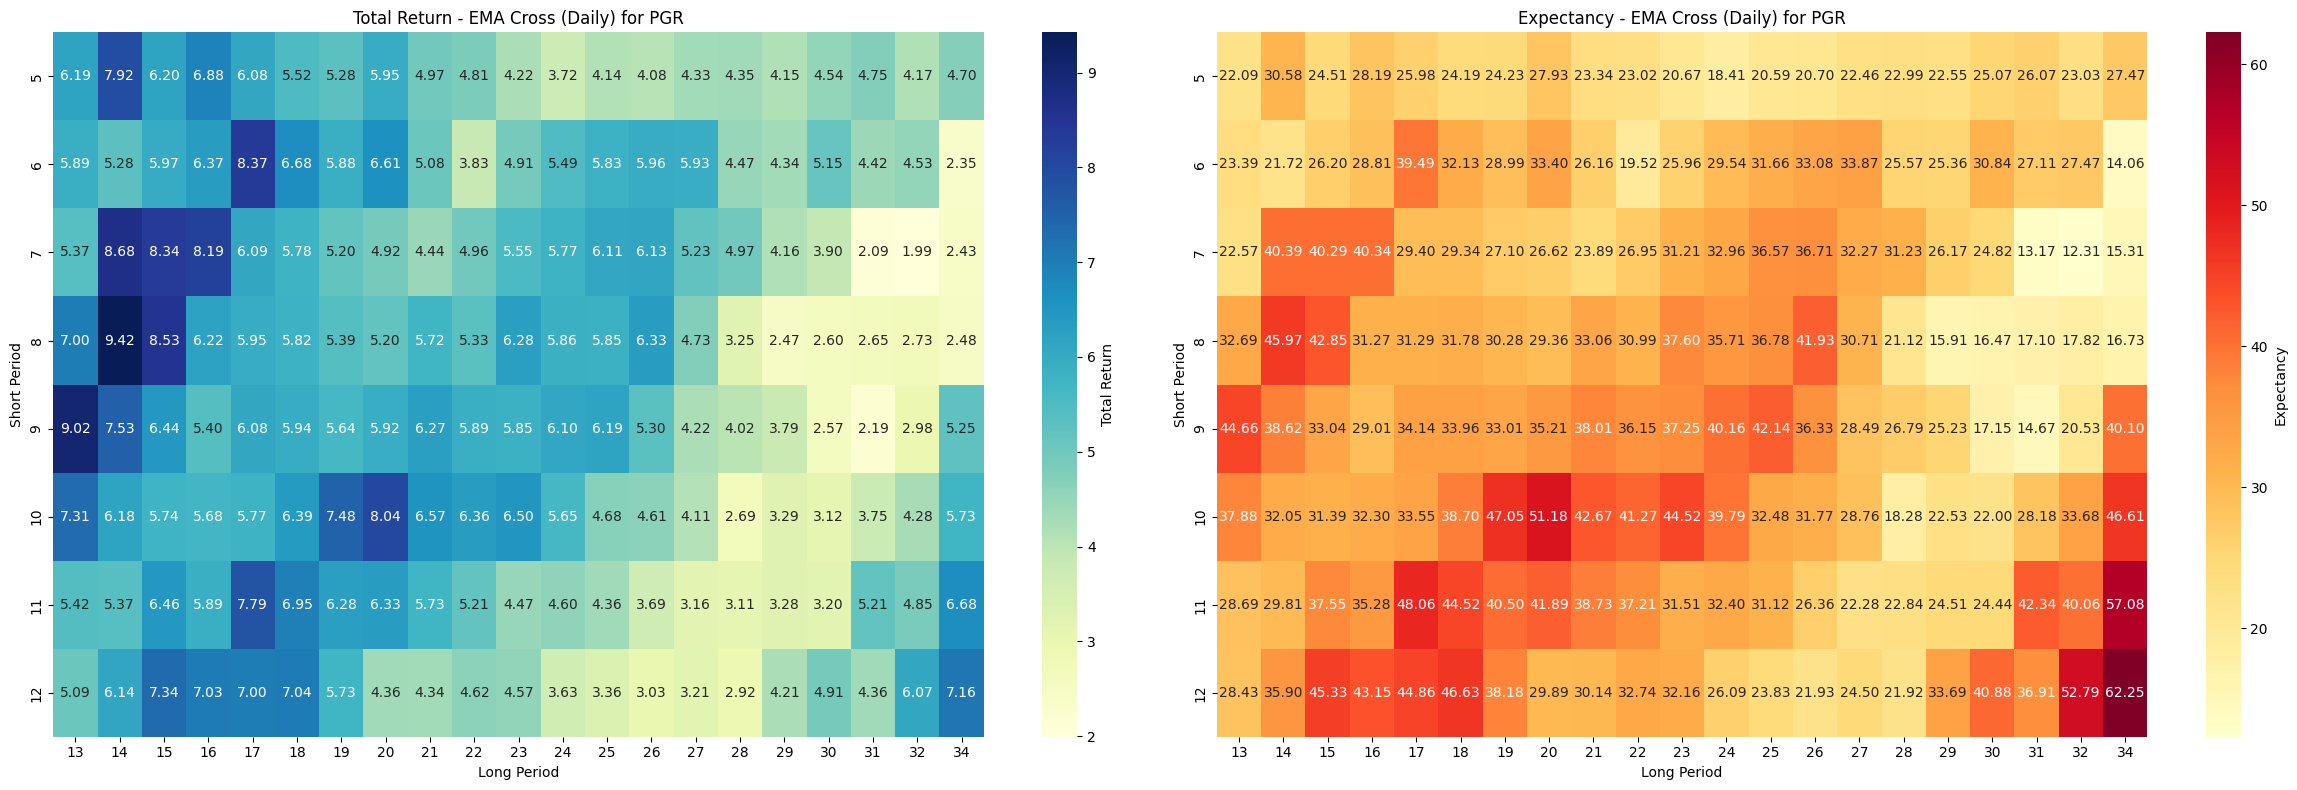

In [8]:
def run() -> None:
    """Main execution method."""
    logging.info("Execution started")
    try:
        short_windows = np.linspace(5, 12, 8, dtype=int)
        long_windows = np.linspace(13, 34, 21, dtype=int)
        
        if USE_SYNTHETIC:
            # Download historical data for TICKER_1 and TICKER_2
            data_ticker_1 = download_data(TICKER_1, USE_HOURLY_DATA)
            data_ticker_2 = download_data(TICKER_2, USE_HOURLY_DATA)
            
            # Create synthetic ticker XY
            data_ticker_1['Close'] = data_ticker_1['Close'].fillna(method='ffill')
            data_ticker_2['Close'] = data_ticker_2['Close'].fillna(method='ffill')
            data_ticker_3 = pd.DataFrame(index=data_ticker_1.index)
            data_ticker_3['Close'] = data_ticker_1['Close'] / data_ticker_2['Close']
            data_ticker_3 = data_ticker_3.dropna()
            data = data_ticker_3
            
            # Extracting base and quote currencies from tickers
            base_currency = TICKER_1[:3]  # X
            quote_currency = TICKER_2[:3]  # Y
            synthetic_ticker = base_currency + quote_currency
        else:
            # Download historical data for TICKER_1 only
            data = download_data(TICKER_1, USE_HOURLY_DATA)
            synthetic_ticker = TICKER_1

        results_return, results_expectancy = parameter_sensitivity_analysis(data, short_windows, long_windows)
        short_window_return, long_window_return, _, _ = print_best_parameters(results_return, results_expectancy, synthetic_ticker)
        
        # Perform final backtest with best parameters
        ma_type = "SMA" if USE_SMA else "EMA"
        print(f"\nPerformance metrics for {synthetic_ticker} using {ma_type}:")
        data = calculate_ma_and_signals(data, short_window_return, long_window_return)
        portfolio = backtest_strategy(data)      
        print(portfolio.stats())
        plot_heatmaps(results_return, results_expectancy, synthetic_ticker)
        
        logging.info("Execution finished successfully")
    except Exception as e:
        logging.error(f"Execution failed: {e}")
        raise

# Run the main execution
run()